## Afternoon practical day 4

Welcome to the final practical of today. Here you'll be working with sequence data, first getting to the point that you have the sequences all aligned, and then using the distances you can only really calculate then to get a clustering of the sequences. As always, first run the two cells below. 



In [1]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn
import itertools
from Bio import SeqIO

In [22]:
# important functions

def calcEucliDist(vectorOne, vectorTwo):
    return np.linalg.norm(vectorOne-vectorTwo, axis = 1)

def calcAbsDist(vectorOne, vectorTwo):
    #using linalg.norm:
    return np.linalg.norm(vectorOne-vectorTwo, ord = 1, axis = 1)

def makeKMeanClusters(X, k, funName = "calcEucliDist", maxIter = 50, nClusteringsToPerform = 20):
    if k <= 0:
        print("K must be greater than 0!")
        return None
    if k > len(X):
        print("K cannot be larger than the # of samples in your data!")
        return None
    if maxIter <= 0:
        print("Cannot have negative or 0 iterations!")
        return None
    
    resultToReturn = [None, None, None, None]
    bestDistortion = np.Inf
    
    for clusteringIndex in range(0, nClusteringsToPerform):
        initialCentroids   = X[np.random.choice(X.shape[0], k, replace=False), :]
        if len(initialCentroids) != k:
            print("Centroids lost!")
        centroids          = initialCentroids
        threeLastCentroids = []
        #print(centroids)
        for i in range(0, maxIter):

            threeLastCentroids.append(np.round(centroids, 4))
            distancesToCentroids = np.vstack([globals()[funName](centroids, datapoint) for datapoint in X])
            closestCentroid      = np.where(distancesToCentroids == np.amin(distancesToCentroids,
                                                                            axis = 1)[:, np.newaxis])[1]
            centroids            = np.vstack([np.mean(X[np.where(closestCentroid == clusterNum)],
                                                      axis = 0) for clusterNum in np.unique(closestCentroid)])

            if i >2:
                threeLastCentroids.pop(0)
                if np.array_equal(threeLastCentroids[-1],threeLastCentroids[-2]) and np.array_equal(threeLastCentroids[-2], threeLastCentroids[-3]):
                    print("No changes in cluster centroids detected in last 3 iterations. Finished at iteration " + str(i+1) + ".")
                    break
        
        # new code
        squareDistancesPerPoint = []
        for index, centroid in enumerate(closestCentroid):
            squareDistancesPerPoint.append(np.square(centroids[centroid, :] - X[index, :]))
        distortion = 1/len(X) * np.sum(np.array(squareDistancesPerPoint))
        
        if distortion < bestDistortion:
            bestDistortion = distortion
            resultToReturn = [centroids, closestCentroid, initialCentroids, bestDistortion]
                
    return resultToReturn

def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average", displayDistMatrix = False):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys():
        print("Error, please input a valid distance function name!")
    
    # make an empty distance matrix
    distanceMatrix = np.zeros(shape = (len(X), len(X)))
    distanceMatrix.fill(np.nan)
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    for rowIndex, row in enumerate(distanceMatrix):
        for colIndex, cellValue in enumerate(row):
            # distance from yourself to yourself is 0, don't calculate!
            if colIndex == rowIndex:
                continue
            # in the first loop, you calculate distance from 1 to 2.
            # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
            if colIndex < rowIndex:
                continue

            distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                             X[colIndex, :][np.newaxis, :])
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            distance = 0
            distanceSingleLink = np.Inf # need this because for single linkage you want lowest distance to be selected
                                        # so need to have the starting distance always be lower.
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    distance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "complete":
                    # for a cluster, if the distance between two points is larger than the current largest distance
                    # between points in a cluster, that is the new cluster distance.
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] > distance:
                        distance = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "single":
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] < distanceSingleLink:
                        distanceSingleLink = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]

            if linkageMethod == "average":
                totalAvgDistance = distance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            if linkageMethod == "complete":
                if distance < distToCluster:
                    distToCluster       = distance
                    dataPointsToCluster = combo

            if linkageMethod == "single":
                if distanceSingleLink < distToCluster:
                    distToCluster       = distanceSingleLink
                    dataPointsToCluster = combo

        #make a new list of clusters
        clusterIndicesMergedList.append(dataPointsToCluster)
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster) in one list by appending to that the current clusters      
        clusteringOverIterations.append(clusterList)
        
        #addition to make a list of lists of everything:
        
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]


def drawHierarchicalClustering(hierarClusterOutcome, figsize = (25,8), title = "Plot", labels = None):
    clusterListX       = hierarClusterOutcome[0]
    clusteredPerStepX  = hierarClusterOutcome[2]
    xLabels            = np.array(list(itertools.chain(*clusterListX[-1])))
    
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks(range(0, len(xLabels)))
    if not labels is None:
        labels = np.array(labels)
        if len(labels) == len(xLabels):
            labels = labels[xLabels]
            ax.set_xticklabels(labels, rotation = 90)      
        else:
            print("Labels supplied should be of same length as the amount of data points!")
            return None
    else:   
        ax.set_xticklabels(xLabels)
    ax.margins(y=0)

    heightPerDataPointPreviousStep = np.array([0] * len(xLabels))
    for i, clusterStep in enumerate(clusteredPerStepX):
        pos1Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[0]])
        pos1Avg       = np.mean(pos1Positions)
        #pos1Start     = np.min(pos1Positions)
        #pos1End       = np.max(pos1Positions)
        pos1ClustSize = len(pos1Positions)
        pos2Positions = np.array([np.where(xLabels == elem)[0] for elem in clusterStep[1]])
        pos2Avg       = np.mean(pos2Positions)
        #pos2Start     = np.min(pos2Positions)
        #pos2End       = np.max(pos2Positions)
        pos2ClustSize = len(pos2Positions)



        heightEnd   = max(pos1ClustSize, pos2ClustSize)
        ax.plot([pos1Avg, pos1Avg], [heightPerDataPointPreviousStep[pos1Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos2Avg, pos2Avg], [heightPerDataPointPreviousStep[pos2Positions[0][0]],heightEnd], color = "black")
        ax.plot([pos1Avg, pos2Avg], [heightEnd,heightEnd], color = "black")

        heightPerDataPointPreviousStep[np.ravel(pos1Positions)] += heightEnd - heightPerDataPointPreviousStep[pos1Positions[0][0]]
        heightPerDataPointPreviousStep[np.ravel(pos2Positions)] += heightEnd - heightPerDataPointPreviousStep[pos2Positions[0][0]]

    ax.set_ylim(0, max(heightPerDataPointPreviousStep)+1)
    fig.suptitle(title)

    plt.show(fig)

## Implementing Needleman-Wunsch for pairwise alignment

Before we can even think about clustering sequence data, we need a way to construct multiple sequence alignments. As you've been told, an often-used method (though it cannot guarantee the best possible MSA) is progressive tree alignment. There, you first make a hierarchical tree of the sequences based on some measure of how alike they are, and then align the most alike sequences, then align the next most alike to those two, etc. etc. until you've aligned all. In that way, you deal with the issue that with, say, 100 sequences that you all want to align together, you have so many possibilities that it's impossible to do, and you probably have many as good options (so which one, then, to pick?).

So you want to cluster sequence data. Well, you need this pairwise measure of similarity (or its inverse, distance). For that, the classic option is Needleman-Wunsch, a dynamic programming algorithm that breaks the problem of finding the global optimal alignment into the subproblem of finding the best subalignments possible, then tracing back from the maximum score to the beginning. We're going to be implementing this algorithm ourselves. Doubtless you have seen this once or twice, but you may need a refresher. Take your pick:

* [Video tutorial](https://www.youtube.com/watch?v=LhpGz5--isw)
* [Wikipedia](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm)

Let's implement it. First as a set of commands, then in a function, so we can use pairwise alignment to make a guide tree. We'll go in parts. The first part is making the table of scores. To do this:
* Initialise an array of zeros of size len(sequence1)+1 by len(sequence2)+1. Fill it with `np.nan`.
* Using the gap, match, and mismatch penalties below, fill in the table. To do that:
    * The leftmost column and top row are just filled by adding gap penalties from top to bottom and left to right, respectively
    * The most top left cell should contain 0.
    * The other cells are filled with the maximum score obtained by either:
        1. Stepping from the cell above (opening or extending a gap, i.e. adding the gap penalty to the score of the cell above)
        2. Stepping from the cell to the left (opening or extending a gap, i.e. adding the gap penalty to the score of the cell to the left)
        3. Stepping from the cell to the top left (i.e. diagonally, aligning the two residues, thereby either adding the match score or the mismatch score). <br>
      **Relevant Wikipedia screencap:** ![NW](SnippetNW.PNG)
* Make sure to use the scoring matrix for substitutions (so that we can, if we want, give another scoring matrix!)
* Your final output should be the matrix with scores per position, as described in the video and Wikipedia. We'll do the actual aligning below.

Hints:
* If all goes well, your output score matrix should look something like this (although it will be in Numpy array format rather than this pretty-printed pd.DataFrame format): ![outcome](NWScoreMatrixOutputForTestSequences.PNG) Note that it's perfectly valid if you have the sequences swapped (so seqTwo along the rows and seqOne along the columns).
* You can loop over a matrix/array by doing something like: <br>
`for rowIndex, rowValues in enumerate(array):` <br>
`    for colIndex, colValue in enumerate(rowValues:)` <br>
`        #do stuff` (do add the appropriate tabs)
* You add one row and one column to accomodate the gap penalties along the left and top. This means that if you want to add the mismatch or match for a certain combination of bases, you need to index with something like `seqOne[rowIndex-1]`.
* You can use `baseDict` to make your life easier `(baseDict["C"], baseDict["G"])` will give you the indices in the score matrix for this mismatch between a C and a G. So `scoreMatrix[baseDict["C"], baseDict["G"]]` will give you the value you want if there's a C in sequence one and a G in sequence two that you possibly want to mismatch.


In [3]:
seqOne        = 'ATGCTTCG'
seqTwo        = 'ATGGCTGCCCC'
matchScore    = 1
mismatchScore = -1
gapScore      = -1

bases = ["A", "T", "G", "C"]
baseDict = dict(zip(bases, [0, 1, 2, 3]))
scoreMatrix = np.zeros(shape = (len(bases), len(bases)))
scoreMatrix[:] = mismatchScore
np.fill_diagonal(scoreMatrix, matchScore)


printTable = pd.DataFrame(scoreMatrix) ; printTable.columns = bases ; printTable.set_index(pd.Index(bases), inplace= True)
print("Substitution matrix for our simple case:")
display(printTable)


# answer
lengthSeqOne = len(seqOne)
lengthSeqTwo = len(seqTwo)
matrix = np.zeros(shape = (lengthSeqOne + 1, lengthSeqTwo +1))
matrix.fill(np.nan)
matrix[1:,0] = np.array(list(range(1, lengthSeqOne+1)) ) * gapScore
matrix[0,1:] = np.array(list(range(1, lengthSeqTwo+1)) ) * gapScore
matrix[0,0] = 0
print("Score matrix with only gap penalties and top left cell filled in:")
print(matrix)

for rowIndex, row in enumerate(matrix):
    for colIndex, position in enumerate(row):
        #skip the values we've already filled in
        if not np.isnan(position):
            continue
        else:
            scoreTop          = matrix[rowIndex-1, colIndex] + gapScore
            #print(matrix[rowIndex, colIndex])
            #print(matrix[rowIndex, colIndex-1])
            scoreLeft         = matrix[rowIndex, colIndex-1] + gapScore
            # since we added a row and a column to allow for the gap penalties in the matrix
            # we need to take rowIndex-1 and colIndex -1 in the sequence
            currentBaseSeqOne = seqOne[rowIndex-1]
            currentBaseSeqTwo = seqTwo[colIndex-1]
            scoreTopLeft      = matrix[rowIndex-1, colIndex-1] + scoreMatrix[baseDict[currentBaseSeqOne],
                                                                       baseDict[currentBaseSeqTwo]]
            scoreArray        = np.array([scoreLeft, scoreTopLeft, scoreTop])
            bestStep          = np.max(scoreArray)
            matrix[rowIndex, colIndex] = bestStep

# make dataFrame for visualisation
displayDf = pd.DataFrame(matrix)
displayDf.columns = ["0"] + list(seqTwo)
displayDf.set_index(pd.Index(["0"] + list(seqOne)), inplace = True)
print("Final scores from Needleman-Wunsch algorithm:")
display(displayDf)



Substitution matrix for our simple case:


,A,T,G,C
A,1.0,-1.0,-1.0,-1.0
T,-1.0,1.0,-1.0,-1.0
G,-1.0,-1.0,1.0,-1.0
C,-1.0,-1.0,-1.0,1.0


Score matrix with only gap penalties and top left cell filled in:
[[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11.]
 [ -1.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -2.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -3.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -4.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -5.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -6.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -7.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -8.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]
Final scores from Needleman-Wunsch algorithm:


,0,A,T,G,G,C,T,G,C,C,C,C
0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0,-11.0
A,-1.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0
T,-2.0,0.0,2.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0
G,-3.0,-1.0,1.0,3.0,2.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0
C,-4.0,-2.0,0.0,2.0,2.0,3.0,2.0,1.0,0.0,-1.0,-2.0,-3.0
T,-5.0,-3.0,-1.0,1.0,1.0,2.0,4.0,3.0,2.0,1.0,0.0,-1.0
T,-6.0,-4.0,-2.0,0.0,0.0,1.0,3.0,3.0,2.0,1.0,0.0,-1.0
C,-7.0,-5.0,-3.0,-1.0,-1.0,1.0,2.0,2.0,4.0,3.0,2.0,1.0
G,-8.0,-6.0,-4.0,-2.0,0.0,0.0,1.0,3.0,3.0,3.0,2.0,1.0


## Adding the steps taken and constructing the sequence alignment

There's only two ingredients missing to get our alignment working:
1. We need to keep a record when we select the max value for our score table (either by moving from the left, top-left, or top) where we came from. This record is non-unique (we could get the same score for a gap as a mismatch, say).
2. Finally, we need to use this record to step back from the bottom right to the top left, going through the directions we saved. In real life, you'd want to report the alternative alignments possible. Here, we will just make one (remember, they are all as good as each other).

To do this:
* Copy your code from above into the cell below.
* Make an extra matrix called `stepMatrix` like so: `np.zeros_like(YourNameForTheScoreMatrixAbove).tolist()` (the tolist is because a numpy array only allows one value per cell. But we might want to store \['left', 'topleft'\] in one cell because we have two options).
* Your code already determined what the maximum score was. All you need to add is to check which entries gave that top score (an alignment/mismatch step (from topleft) or a gap step (from the left or from the top)) and add that as a value in `stepMatrix`. So you'd do something like `stepMatrix[rowIndex][colIndex] = ['left', 'topleft']`, if for a certain step both the step from the left cell and the top-left cell yield the same, maximum, score.

When that's done, you can move on to making the alignment. There's many slighly different ways to go about it, of course, but here's one idea:
* Start a rowIndex at `len(seqOne)`; start a colIndex at `len(seqTwo)`.
* Start two empty strings, `seqOneAligned` and `seqTwoAligned`.
* While both indices are not yet 0 (i.e. you are not yet at the top left):
    * Select the first entry from the stepMatrix at that position (there could be more, but for now we just make one of the optimal alignments).
    * If that entry is 'left', add "-" to `seqTwoAligned` and the letter at `seqOne[rowIndex-1]` to `seqOneAligned`, and subtract one from rowIndex.
    * If that entry is 'top', do the opposite (gap to seq one, letter to seq two, subtract one from colIndex)
    * If that entry is 'topleft', add both corresponding letters, and subtract one from both rowIndex and colIndex
* When done, reverse the two sequences (they're now back-to-front) and voila: aligned sequences!


In [4]:
# your answer here:



# answer
lengthSeqOne = len(seqOne)
lengthSeqTwo = len(seqTwo)
matrix = np.zeros(shape = (lengthSeqOne + 1, lengthSeqTwo +1))
matrix.fill(np.nan)
matrix[1:,0] = np.array(list(range(1, lengthSeqOne+1)) ) * gapScore
matrix[0,1:] = np.array(list(range(1, lengthSeqTwo+1)) ) * gapScore
matrix[0,0] = 0
print(matrix)
stepMatrix = np.zeros_like(matrix).tolist()
# go over the rows, skipping what was already filled in
for rowIndex, row in enumerate(matrix):
    for colIndex, position in enumerate(row):
        #skip the values we've already filled in
        if not np.isnan(position):
            continue
        else:
            scoreTop          = matrix[rowIndex-1, colIndex] + gapScore
            #print(matrix[rowIndex, colIndex])
            #print(matrix[rowIndex, colIndex-1])
            scoreLeft         = matrix[rowIndex, colIndex-1] + gapScore
            # since we added a row and a column to allow for the gap penalties in the matrix
            # we need to take rowIndex-1 and colIndex -1 in the sequence
            currentBaseSeqOne = seqOne[rowIndex-1]
            currentBaseSeqTwo = seqTwo[colIndex-1]
            scoreTopLeft      = matrix[rowIndex-1, colIndex-1] + scoreMatrix[baseDict[currentBaseSeqOne],
                                                                       baseDict[currentBaseSeqTwo]]
            scoreArray        = np.array([scoreLeft, scoreTopLeft, scoreTop])
            bestStep          = np.max(scoreArray)
            matrix[rowIndex, colIndex] = bestStep
            # save from which cell the best step was, could be more than one option
            locationBestStep = np.where(scoreArray == bestStep)
            bestStepCoords   = np.array(["left", "topleft", "top"])
            stepMatrix[rowIndex][colIndex] = bestStepCoords[locationBestStep[0]]

# make dataFrame for visualisation
displayDf = pd.DataFrame(matrix)
displayDf.columns = ["0"] + list(seqTwo)
displayDf.set_index(pd.Index(["0"] + list(seqOne)), inplace = True)
display(displayDf)

#traceback, make the alignment. For now we will always pick the first option

rowIndexAlign = len(seqOne) 
colIndexAlign = len(seqTwo) 
seqOneAligned = ""
seqTwoAligned = ""
while rowIndexAlign != 0 and colIndexAlign != 0:
    direction = stepMatrix[rowIndexAlign][colIndexAlign][0]
    if direction == 'left':
        moveInRows = 0; moveInCols = 1 # align a gap to seq Two
        seqOneAligned += "-"
        seqTwoAligned += list(seqTwo)[colIndexAlign-1]
        
    elif direction == "topleft": 
        moveInRows = 1; moveInCols = 1 # align letters, get match or mismatch
        seqOneAligned += list(seqOne)[rowIndexAlign-1]
        seqTwoAligned += list(seqTwo)[colIndexAlign-1]
        
    else: # 'top'
        moveInRows = 1; moveInCols = 0 # align a gap to seq One
        seqTwoAligned += "-"
        seqOneAligned += list(seqOne)[rowIndexAlign-1]
        
    rowIndexAlign -= moveInRows
    colIndexAlign -= moveInCols

# final alignment should be reversed since we built it from back to front
seqOneAligned = seqOneAligned[::-1]
seqTwoAligned = seqTwoAligned[::-1]

# print it
print("Aligned sequences: ")
print(seqOneAligned)
print(seqTwoAligned)


[[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11.]
 [ -1.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -2.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -3.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -4.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -5.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -6.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -7.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -8.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]]


,0,A,T,G,G,C,T,G,C,C,C,C
0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,-10.0,-11.0
A,-1.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0
T,-2.0,0.0,2.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0
G,-3.0,-1.0,1.0,3.0,2.0,1.0,0.0,-1.0,-2.0,-3.0,-4.0,-5.0
C,-4.0,-2.0,0.0,2.0,2.0,3.0,2.0,1.0,0.0,-1.0,-2.0,-3.0
T,-5.0,-3.0,-1.0,1.0,1.0,2.0,4.0,3.0,2.0,1.0,0.0,-1.0
T,-6.0,-4.0,-2.0,0.0,0.0,1.0,3.0,3.0,2.0,1.0,0.0,-1.0
C,-7.0,-5.0,-3.0,-1.0,-1.0,1.0,2.0,2.0,4.0,3.0,2.0,1.0
G,-8.0,-6.0,-4.0,-2.0,0.0,0.0,1.0,3.0,3.0,3.0,2.0,1.0


Aligned sequences: 
ATG-CTTCG--
ATGGCTGCCCC


## Making a function out of this.

Now, functionalise what you've been implementing so far. Call the function `alignNW()`, give it 4 arguments `(seqOne, seqTwo, substitutionMatrix = scoreMatrix, substitutionDict = baseDict)`. It should return a dictionary with three entries: "similarityScore", "seqOneAligned", and "seqTwoAligned". similarityScore is just the bottom right value in the score matrix: it is the measure of how similar the two sequences are based on their alignment. The other two speak for themselves. As a sanity check, `alignNW('CCC', 'CCC')` should return a score of 3, while `alignNW('ATG', 'GTA')` should return -1.

Note: don't print anything anymore if you did before. We're going to use this function a lot of times!

In [5]:
# set-up
matchScore    = 1
mismatchScore = -1
gapScore      = -1

bases = ["A", "T", "G", "C"]
baseDict = dict(zip(bases, [0, 1, 2, 3]))
scoreMatrix = np.zeros(shape = (len(bases), len(bases)))
scoreMatrix[:] = mismatchScore
np.fill_diagonal(scoreMatrix, matchScore)

#define alignNW


#answer

def alignNW(seqOne, seqTwo, substitutionMatrix = scoreMatrix, substitutionDict = baseDict):
    
    lengthSeqOne = len(seqOne)
    lengthSeqTwo = len(seqTwo)
    matrix = np.zeros(shape = (lengthSeqOne + 1, lengthSeqTwo +1))
    matrix.fill(np.nan)
    matrix[1:,0] = np.array(list(range(1, lengthSeqOne+1)) ) * gapScore
    matrix[0,1:] = np.array(list(range(1, lengthSeqTwo+1)) ) * gapScore
    matrix[0,0] = 0
    stepMatrix = np.zeros_like(matrix).tolist()
    # go over the rows, skipping what was already filled in
    for rowIndex, row in enumerate(matrix):
        for colIndex, position in enumerate(row):
            #skip the values we've already filled in
            if not np.isnan(position):
                continue
            else:
                scoreTop          = matrix[rowIndex-1, colIndex] + gapScore
                #print(matrix[rowIndex, colIndex])
                #print(matrix[rowIndex, colIndex-1])
                scoreLeft         = matrix[rowIndex, colIndex-1] + gapScore
                # since we added a row and a column to allow for the gap penalties in the matrix
                # we need to take rowIndex-1 and colIndex -1 in the sequence
                currentBaseSeqOne = seqOne[rowIndex-1]
                currentBaseSeqTwo = seqTwo[colIndex-1]
                scoreTopLeft      = matrix[rowIndex-1, colIndex-1] + substitutionMatrix[substitutionDict[currentBaseSeqOne],
                                                                           substitutionDict[currentBaseSeqTwo]]
                scoreArray        = np.array([scoreLeft, scoreTopLeft, scoreTop])
                bestStep          = np.max(scoreArray)
                matrix[rowIndex, colIndex] = bestStep
                # save from which cell the best step was, could be more than one option
                locationBestStep = np.where(scoreArray == bestStep)
                bestStepCoords   = np.array(["left", "topleft", "top"])
                stepMatrix[rowIndex][colIndex] = bestStepCoords[locationBestStep[0]]


    #traceback, make the alignment. For now we will always pick the first option

    rowIndexAlign = len(seqOne) 
    colIndexAlign = len(seqTwo) 
    seqOneAligned = ""
    seqTwoAligned = ""
    while rowIndexAlign != 0 and colIndexAlign != 0:
        direction = stepMatrix[rowIndexAlign][colIndexAlign][0]
        if direction == 'left':
            moveInRows = 0; moveInCols = 1 # align a gap to seq Two
            seqOneAligned += "-"
            seqTwoAligned += list(seqTwo)[colIndexAlign-1]

        elif direction == "topleft": 
            moveInRows = 1; moveInCols = 1 # align letters, get match or mismatch
            seqOneAligned += list(seqOne)[rowIndexAlign-1]
            seqTwoAligned += list(seqTwo)[colIndexAlign-1]

        else: # 'top'
            moveInRows = 1; moveInCols = 0 # align a gap to seq One
            seqTwoAligned += "-"
            seqOneAligned += list(seqOne)[rowIndexAlign-1]

        rowIndexAlign -= moveInRows
        colIndexAlign -= moveInCols

    # final alignment should be reversed since we built it from back to front
    seqOneAligned = seqOneAligned[::-1]
    seqTwoAligned = seqTwoAligned[::-1]
    
    returnDict = {"similarityScore": matrix[-1, -1], "seqOne": seqOneAligned, "seqTwo": seqTwoAligned}
    return returnDict

# sanity checks
print(alignNW("CCC", "CCC")["similarityScore"])
print(alignNW("ATG", "GTA")["similarityScore"])

3.0
-1.0


## Data for constructing a guide tree

The reason I'm suddenly making you implement pairwise alignment is that if I ask you to cluster sequences, you won't be able to do it just like that. The reason for that is that, while in the morning practicals we had data points with features 1 to _n_ for each of them, for sequences you don't know which letter is which feature. Maybe the 3rd letter in sequence 43 actually corresponds to the 7th letter in sequence 22, because of deletions or duplications. To know what corresponds to what, we need a multiple sequence alignment.

That sounds fine and dandy, but as you've heard, making a multiple sequence alignment of a 100 sequences together is basically impossible: there are so many options it's infeasible to calculate. So we compromise, getting a very good (but not per se optimal) MSA by doing _progressive tree alignment_: we get some notion of pairwise distances between sequences (either via pairwise alignment or k-mer or k-tuple methods), and then align the two closest sequences, then the one that's closest to either of those two, etc.

Now that we have Needleman-Wunsch (NW), I'd like you to construct a guide tree. Note that the final score in the lower right of the NWscore matrix is the similarity score for two sequences, so the inverse of their distance. Below I give you 50 sequences of ribosomal 16S subunits, which I randomly selected from the RDP database unaligned data file that can be found [here](http://rdp.cme.msu.edu/misc/resources.jsp). We will be aligning the first 80 bases of 25 of those: I thought I could let you align the 1225 unique combinations of 50 by 50 full sequences, but that would take _ages_ with our naive implementation (which shows you how dire the problem of computational expense can be)!

We'll be using the [DNAFULL scoring matrix](https://rosalind.info/glossary/dnafull/), which includes all the iupac symbols for nucleotide sequences (like N for 'any nucleotide at this position, we don't know which, only that there is a nucleotide here'). 

* Make a matrix of zeros of size 25\*25. 
* Align all unique combinations of the 25 16S rRNA subsequences in `sequences` using the indices in `combinations`. Save them in a similarity matrix.
* Make the similarity matrix into a distance matrix by: 
    * Adding (-(minimum score in matrix) +1) to all entries (there could be negative scores)
    * Doing 1/score (so very high similarity of 100 becomes 1/100 = small distance, while 1/1 (completely dissimilar) is just 1.


In [6]:
# advanced scoring matrix:

scoreMatDNAFULL = np.array([ [ 5,  -4,  -4,  -4,  -4,   1,   1,  -4,  -4,   1,  -4,  -1,  -1,  -1,  -2],
            [-4,   5,  -4,  -4,  -4,   1,  -4,   1,   1,  -4,  -1,  -4,  -1,  -1,  -2],
            [-4, -4,   5,  -4,   1,  -4,   1,  -4,   1,  -4,  -1,  -1,  -4,  -1,  -2],
            [-4,  -4,  -4,   5,   1,  -4,  -4,   1,  -4,   1,  -1,  -1,  -1,  -4,  -2],
[-4,  -4,   1,   1,  -1,  -4,  -2,  -2,  -2,  -2,  -1,  -1,  -3,  -3,  -1],
[1,   1,  -4,  -4,  -4,  -1,  -2,  -2,  -2,  -2,  -3,  -3,  -1,  -1,  -1],
[1,  -4,   1,  -4,  -2,  -2,  -1,  -4,  -2,  -2,  -3,  -1,  -3,  -1,  -1],
[-4,   1,  -4,   1,  -2,  -2,  -4,  -1,  -2,  -2,  -1,  -3,  -1,  -3,  -1],
[-4,   1,   1,  -4,  -2,  -2,  -2,  -2,  -1,  -4,  -1,  -3,  -3,  -1,  -1],
[1,  -4,  -4,   1,  -2,  -2,  -2,  -2,  -4,  -1,  -3,  -1,  -1,  -3,  -1],
[-4,  -1,  -1,  -1,  -1,  -3,  -3,  -1,  -1,  -3,  -1,  -2, -2,  -2,  -1],
[-1,  -4,  -1,  -1,  -1,  -3,  -1,  -3,  -3,  -1,  -2,  -1,  -2,  -2,  -1],
[-1,  -1,  -4,  -1,  -3,  -1,  -3,  -1,  -3,  -1,  -2,  -2,  -1,  -2,  -1], 
[-1,  -1,  -1,  -4,  -3,  -1,  -1,  -3,  -1,  -3,  -2,  -2,  -2,  -1,  -1],
[-2,  -2,  -2,  -2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]])

basesDNAFULL = ["A", "T", "G", "C", "S", "W", "R", "Y", "K", "M", "B", "V", "H", "D", "N"]
dictDNAFULL = dict(zip(basesDNAFULL, range(0, len(basesDNAFULL))))


# reading data
file_in               = "firstFifty16SSequences.fasta"
sequenceDict          = SeqIO.to_dict(SeqIO.parse(open(file_in, mode='r'), 'fasta'))
finalBasePosToInclude = 80
nSequencesToUse       = 25
sequences = [str(elem.seq).upper()[0:finalBasePosToInclude] for index, elem in enumerate(list(sequenceDict.values())) if index <nSequencesToUse]

# again, we don't want to align seq 1 with seq 2 and seq 2 with seq 1, they're the same
# combinations gets the unique combinations for us.
combinations = list(itertools.combinations(range(0, len(sequences)), 2))
print("Alignments to perform: " + str(len(combinations)))

#up to you!


#answer

pairWiseDistMat = np.zeros(shape = (len(sequences), len(sequences)))
# doing pairwise alignment
for index, (seqOneIndex, seqTwoIndex) in enumerate(combinations):
    #print(index)
    score = alignNW(sequences[seqOneIndex], sequences[seqTwoIndex],
                    substitutionMatrix= scoreMatDNAFULL, 
                    substitutionDict= dictDNAFULL)["similarityScore"]
    pairWiseDistMat[seqOneIndex, seqTwoIndex] = score

pairWiseDistMat = 1/(pairWiseDistMat + (-np.min(pairWiseDistMat) + 1))

Alignments to perform: 300


## Making the guide tree

Now all we need to do is construct a hierarchical tree out of the sequence distances and we'll know how to do progressive tree alignment. For that, we need to change our hierarCluster function, allowing it to skip calculating distances and instead make a clustering on pre-defined distances. To do this:

* Add an argument `distMatrix = None` to the function below
* If `distMatrix` is not None, it should use the pre-calculated distance matrix instead and skip the whole distance calculation step. 
* Run this updated function, with X just being `sequences` from above.
* Use `drawHierarchicalClustering` to see the results. 
* Check that the first two sequences that are clustered correspond to the minimum of the distance matrix you calculated in the previous cell. Notice anything strange?

Hint:
* For the last point you can use `np.where()` and `np.min()`.

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.003378,0.005882,0.004717,0.004425,0.006410,0.002959,0.002681,0.003378,0.003378,...,0.003378,0.005650,0.005236,0.003378,0.005236,0.005236,0.005236,0.005051,0.005051,0.005051
1,1.0,1.000000,0.004717,0.004425,0.004878,0.005435,0.003021,0.003155,0.002494,0.002494,...,0.002494,0.004717,0.005051,0.002494,0.004878,0.005051,0.005051,0.004566,0.004717,0.004566
2,1.0,1.000000,1.000000,0.005435,0.006135,0.005882,0.005650,0.005236,0.004717,0.004717,...,0.004717,0.002538,0.005051,0.004717,0.005236,0.005236,0.005051,0.005435,0.005650,0.005435
3,1.0,1.000000,1.000000,1.000000,0.004717,0.005848,0.004878,0.004717,0.004425,0.004425,...,0.004425,0.005236,0.005236,0.004425,0.005236,0.005435,0.005435,0.004566,0.005051,0.004717
4,1.0,1.000000,1.000000,1.000000,1.000000,0.005650,0.004566,0.004566,0.004878,0.004878,...,0.004878,0.006135,0.003636,0.004878,0.004425,0.003731,0.003731,0.005882,0.005236,0.005650
5,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.006135,0.005882,0.005435,0.005435,...,0.005435,0.006135,0.005882,0.005435,0.005435,0.006135,0.005882,0.005435,0.005435,0.005236
6,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002899,0.003021,0.003021,...,0.003021,0.005650,0.005051,0.003021,0.005051,0.005051,0.005051,0.004878,0.004878,0.004717
7,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.003155,0.003155,...,0.003155,0.005236,0.004878,0.003155,0.005051,0.004717,0.004717,0.004717,0.004878,0.004566
8,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.002494,...,0.002494,0.004717,0.005051,0.002494,0.004878,0.005051,0.005051,0.004566,0.004717,0.004566
9,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.002494,0.004717,0.005051,0.002494,0.004878,0.005051,0.005051,0.004566,0.004717,0.004566


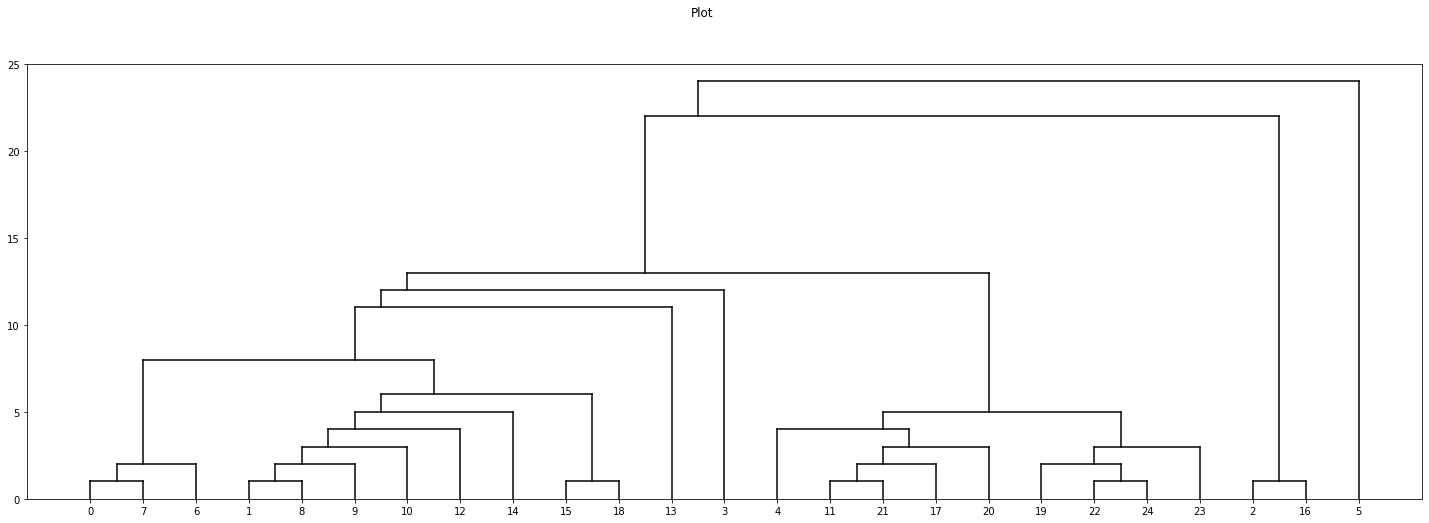

Indices that have the same, minimum, distance: 
[(1, 8), (1, 9), (1, 10), (1, 12), (1, 14), (1, 15), (1, 18), (8, 9), (8, 10), (8, 12), (8, 14), (8, 15), (8, 18), (9, 10), (9, 12), (9, 14), (9, 15), (9, 18), (10, 12), (10, 14), (10, 15), (10, 18), (12, 14), (12, 15), (12, 18), (14, 15), (14, 18), (15, 18)]
minimum dist:
0.0024937655860349127
3 sample indices with this minimal distance:
(1, 15)
0.0024937655860349127
(8, 14)
0.0024937655860349127
(8, 18)
0.0024937655860349127
(15, 18)
0.0024937655860349127


In [54]:
# Your answr here

#answer

def hierarCluster(X, distanceFunc = "calcEucliDist", linkageMethod = "average",
                  displayDistMatrix = False, distMatrix = None):
    
    if linkageMethod not in ["average", "complete", "single"]:
        print("Error, please input a valid linkage method!")
        return None
    if distanceFunc  not in globals().keys() and distMatrix == None :
        print("Error, please input a valid distance function name!")
    
    # make a list with the indices of every data point. This is the list of clusters, where you start
    # with every point in a cluster and then start merging them.
    initialList = [[index] for index, _ in enumerate(X)]
    clusterList = initialList.copy()
    clusteringOverIterations = []
    clusteringOverIterations.append(initialList)
    # also make an empty list that saves which cluster indices were merged for every iteration
    clusterIndicesMergedList = []
    
    if distMatrix is None:
        # make an empty distance matrix
        distanceMatrix = np.zeros(shape = (len(X), len(X)))
        distanceMatrix.fill(np.nan)


        for rowIndex, row in enumerate(distanceMatrix):
            for colIndex, cellValue in enumerate(row):
                # distance from yourself to yourself is 0, don't calculate!
                if colIndex == rowIndex:
                    continue
                # in the first loop, you calculate distance from 1 to 2.
                # in the second loop, you don't want to calculate distance from 2 to 1 again. This safeguards against that.
                if colIndex < rowIndex:
                    continue

                distanceMatrix[rowIndex, colIndex] = globals()[distanceFunc](X[rowIndex,:][np.newaxis,  :],
                                                                                 X[colIndex, :][np.newaxis, :])
    
    if not distMatrix is None:
        distanceMatrix = distMatrix
    if displayDistMatrix:
        display(pd.DataFrame(distanceMatrix))

    # We continue clustering until everything is in one giant cluster. Thats len(X)-1 clustering steps.
    for i in range(0, len(X)-1):
        # we start with no idea of which two clusters we need to cluster
        lowestDistDatapoints = None
        # since we haven't calculated any distance, our current distance is infinite
        distToCluster = np.Inf
        # clusterList initially looks like [[0], [1], ... [99]].
        # itertools.combinations makes that into [([0], [1]), ([0], [2]), ([0], [3]) ... ([1], [2]), ([1], [3])... (98, 99)]
        # so you get all possible combinations of clusters that you could cluster together
        for combo in itertools.combinations(clusterList, 2):

            distance = 0
            distanceSingleLink = np.Inf # need this because for single linkage you want lowest distance to be selected
                                        # so need to have the starting distance always be lower.
            # make all combinations of data points in the first cluster and data points in the second cluster
            # so if the current combo = ([0, 12, 15], [3, 2]), this results in:
            # [[0, 3], [0, 2], [12, 3], [12, 2], [15, 3], [15,2]]: these are all the points that we need to get
            # the distances for (and average for average linkage)
            toIterate = [j for i in [list(zip([elem] * len(combo[1]), combo[1] )) for elem in combo[0]] for j in i]
            for indicesTwoDatapoints in toIterate:
                #sort the indices. Our matrix has only the distance between 1 and 2, not between 2 and 1.
                #this turns [12, 2] from above into [2, 12], etc.
                indicesTwoDatapoints = sorted(indicesTwoDatapoints)

                # keep a running total of all distances between the points in the two clusters
                if linkageMethod == "average":
                    distance += distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "complete":
                    # for a cluster, if the distance between two points is larger than the current largest distance
                    # between points in a cluster, that is the new cluster distance.
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] > distance:
                        distance = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]
                if linkageMethod == "single":
                    if distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]] < distanceSingleLink:
                        distanceSingleLink = distanceMatrix[indicesTwoDatapoints[0], indicesTwoDatapoints[1]]

            if linkageMethod == "average":
                totalAvgDistance = distance/(len(combo[0]) * len(combo[1]))

            # if distance between these clusters is less than the lowest distance we have seen so far,
            #set these clusters as the ones to cluster. 
                if totalAvgDistance < distToCluster:
                    distToCluster       = totalAvgDistance
                    dataPointsToCluster = combo

            if linkageMethod == "complete":
                if distance < distToCluster:
                    distToCluster       = distance
                    dataPointsToCluster = combo

            if linkageMethod == "single":
                if distanceSingleLink < distToCluster:
                    distToCluster       = distanceSingleLink
                    dataPointsToCluster = combo

        #make a new list of clusters
        clusterIndicesMergedList.append(dataPointsToCluster)
        clusterList = clusterList.copy()
        for index, elem in enumerate(clusterList):
            # merge the second cluster into the first cluster
            if elem == dataPointsToCluster[0]:
                clusterList[index] = clusterList[index] + dataPointsToCluster[1]
                #clusterList2[index] = sorted(clusterList[index])
            # remove the separate second cluster (it's now been merged to the first one)    
            if elem == dataPointsToCluster[1]:
                clusterList.pop(index)
        # Finally, save all clusters, from the very beginning (all separate clusters) until the very end (all in one cluster) in one list by appending to that the current clusters      
        clusteringOverIterations.append(clusterList)
        
        #addition to make a list of lists of everything:
        
    
    return [clusteringOverIterations, pd.DataFrame(distanceMatrix), clusterIndicesMergedList]


clusterSequences = hierarCluster(sequences, displayDistMatrix= True, distMatrix = pairWiseDistMat)
drawHierarchicalClustering(clusterSequences)
rowsEqualDist, colsEqualDist = np.where(pairWiseDistMat == np.min(pairWiseDistMat))
indicesEqualDist = list(zip(rowsEqualDist, colsEqualDist))
print("Indices that have the same, minimum, distance: ")
print(indicesEqualDist)
print("minimum dist:")
print(np.min(pairWiseDistMat))
print("3 sample indices with this minimal distance:")
print(indicesEqualDist[5])
print(pairWiseDistMat[indicesEqualDist[5]])
print(indicesEqualDist[10])
print(pairWiseDistMat[indicesEqualDist[10]])
print(indicesEqualDist[12])
print(pairWiseDistMat[indicesEqualDist[12]])
print(indicesEqualDist[-1])
print(pairWiseDistMat[indicesEqualDist[-1]])

# What you'll find out is that multiple sequences actually have the same, minimum, distance towards each other,
# so one of these is picked. That's not so strange: these are (parts of) ribosomal RNA subunits. We expect
# them to be very similar indeed!

## Calculating similarity scores for guide trees more rapidly

This approach of pairwise alignment also rapidly becomes infeasible, as evidenced by the fact that I only let you align a few sequences, and of those, only part of the sequence, because otherwise it would take too long (with our simple implementation). Nevermind if you have 10.000 or 100.000 sequences to align. Then, different methods, like k-mers or k-tuples are used. We'll implement the k-mer method of distance calculation here for the sequences above. 

K-mers are subsequences of length k in a sequence. So a 1-mer in a nucleotide sequence are just the amount of A, T, G, and C in that sequence. But for 2-mers, you get the amount of AA, AT, TA, TT, GC, CG, GG, CC, CT, TC, TG, GT, AC, CA, AG, GA in it. See this image: <br> ![Kmers](Kmers.PNG)

Note that the k-mers overlap. You might already see the advantage: k-mers are quick to calculate, and they give you a set number of features for each sequence. You can then easily calculate distances based on these features and cluster hierarchically: bam, you have your guide tree! Read more [here](https://en.wikipedia.org/wiki/K-mer).

Let's make a guide tree for the sequences from above (although now all of them, and with their full length) using 2- and 3-mers. The code below is your starting point. Up to you to calculate the k-mer counts for each sequence and do the hierarchical clustering (with Euclidean distance calculation). To do this:

* Make an empty list to hold the features for each sequence.
* Go over each sequence, for each:
    * Make an empty feature vector with 80 spots for every k-mer
    * Glide over the sequence with a sliding window, incrementing the correct spot for the 2-mer and 3-mer you read at each position 
    * Append the features for this sequence to the list you made in the beginning.
* Finally, use `np.vstack()` to stack all these features, you should end up with a 50 by 80 feature matrix X for hierarchical clustering.
* After this, do the hierarchical clustering using average linkage and Euclidean distance, visualise it, and try to see how much it differs from the one with pairwise alignment.

Hints:
* You can increment the 3-mer and 2-mer at the same time, provided you realise that the 3-mer will give an error once the sliding window is at the very end of the string. So you should check that `currentPos+3 is not > len(currentSeq)`
* In the answers, I have done this procedure also for the exact same subsequences as we used above. Look there if you want to.

Each sequence will now have 80 features.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,260.46113,200.159936,265.855224,175.339670,234.548502,7.280110,4.898979,260.153801,259.765279,...,88.124911,134.357731,133.895482,92.822411,175.863583,301.024916,175.550563,176.193076,314.953965,299.315887
1,NaN,NaN,63.513778,17.860571,90.509668,34.684290,259.208410,259.595840,3.162278,4.690416,...,188.960313,135.181360,135.233132,180.111077,94.973681,46.711883,95.278539,94.963151,57.306195,43.266615
2,NaN,NaN,NaN,69.692180,35.242020,42.225585,198.758648,199.213453,63.182276,63.166447,...,132.037873,77.524190,77.188082,122.270193,44.766059,106.207344,45.365185,45.077711,117.770964,103.469802
3,NaN,NaN,NaN,NaN,96.607453,37.389838,264.620483,265.056598,17.691806,18.466185,...,194.141701,140.224819,140.374499,185.372598,98.635693,39.560081,99.010100,98.696504,50.901866,36.235342
4,NaN,NaN,NaN,NaN,NaN,65.734314,174.203904,174.178070,90.055538,89.732937,...,108.664622,48.826222,48.249352,98.721831,28.495614,131.764942,28.142495,30.033315,144.803315,130.284305
5,NaN,NaN,NaN,NaN,NaN,NaN,233.199485,233.681407,34.249088,34.102786,...,163.422765,108.696826,108.944940,154.864457,68.898476,72.958893,69.130312,69.303680,84.764379,71.140706
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.681146,258.884144,258.528528,...,86.700634,133.517789,133.007519,91.635146,174.965711,299.968332,174.731222,175.353928,313.746713,298.186183
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.287485,258.901526,...,87.452844,133.206606,132.717746,92.108632,174.882818,300.326489,174.568038,175.288334,314.197390,298.576623
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.291503,...,188.419744,134.833230,134.870308,179.516016,94.752309,47.053161,95.089432,94.762862,57.688820,43.726422
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187.909553,134.409821,134.506505,178.930154,94.286797,47.074409,94.519839,94.201911,57.930993,43.954522


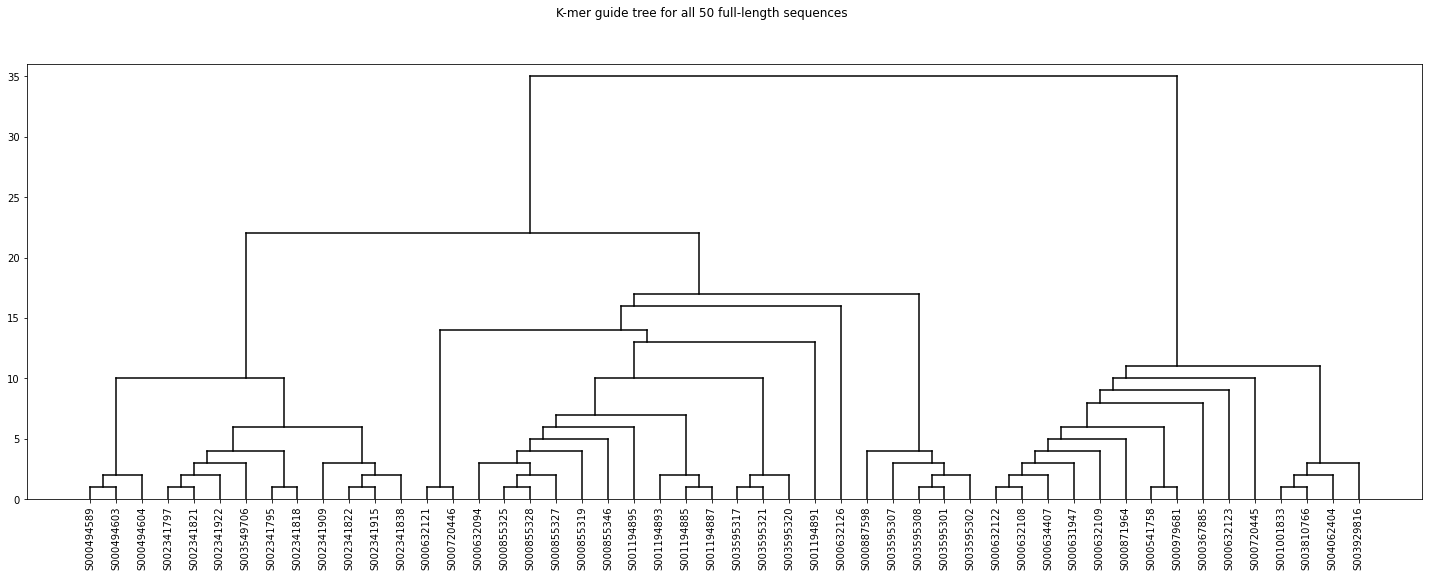

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,8.0,18.11077,14.000000,17.549929,21.000000,6.855655,5.656854,8.000000,8.000000,...,8.000000,18.330303,19.131126,8.000000,18.384776,19.390719,19.131126,16.552945,18.654758,18.110770
1,NaN,NaN,20.78461,15.937377,17.606817,22.516660,8.185353,6.782330,0.000000,0.000000,...,0.000000,20.880613,18.439089,0.000000,17.492856,18.654758,18.973666,15.811388,17.776389,16.792856
2,NaN,NaN,NaN,10.677078,17.606817,15.198684,16.881943,19.646883,20.784610,20.784610,...,20.784610,2.000000,17.378147,20.784610,18.275667,17.888544,18.055470,14.899664,18.973666,16.431677
3,NaN,NaN,NaN,NaN,19.544820,19.824228,14.177447,15.684387,15.937377,15.937377,...,15.937377,11.401754,18.920888,15.937377,19.697716,19.131126,19.697716,14.832397,18.867962,17.320508
4,NaN,NaN,NaN,NaN,NaN,16.643317,14.456832,16.309506,17.606817,17.606817,...,17.606817,17.146428,8.602325,17.606817,8.944272,8.602325,7.874008,12.569805,14.142136,11.045361
5,NaN,NaN,NaN,NaN,NaN,NaN,18.920888,21.794495,22.516660,22.516660,...,22.516660,14.730920,17.349352,22.516660,17.578396,17.860571,17.804494,15.459625,18.083141,15.394804
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.708204,8.185353,8.185353,...,8.185353,17.000000,15.968719,8.185353,15.264338,16.278821,16.093477,13.076697,15.905974,14.387495
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.782330,6.782330,...,6.782330,19.697716,17.435596,6.782330,16.431677,17.720045,17.492856,15.874508,17.549929,16.613248
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,20.880613,18.439089,0.000000,17.492856,18.654758,18.973666,15.811388,17.776389,16.792856
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,20.880613,18.439089,0.000000,17.492856,18.654758,18.973666,15.811388,17.776389,16.792856


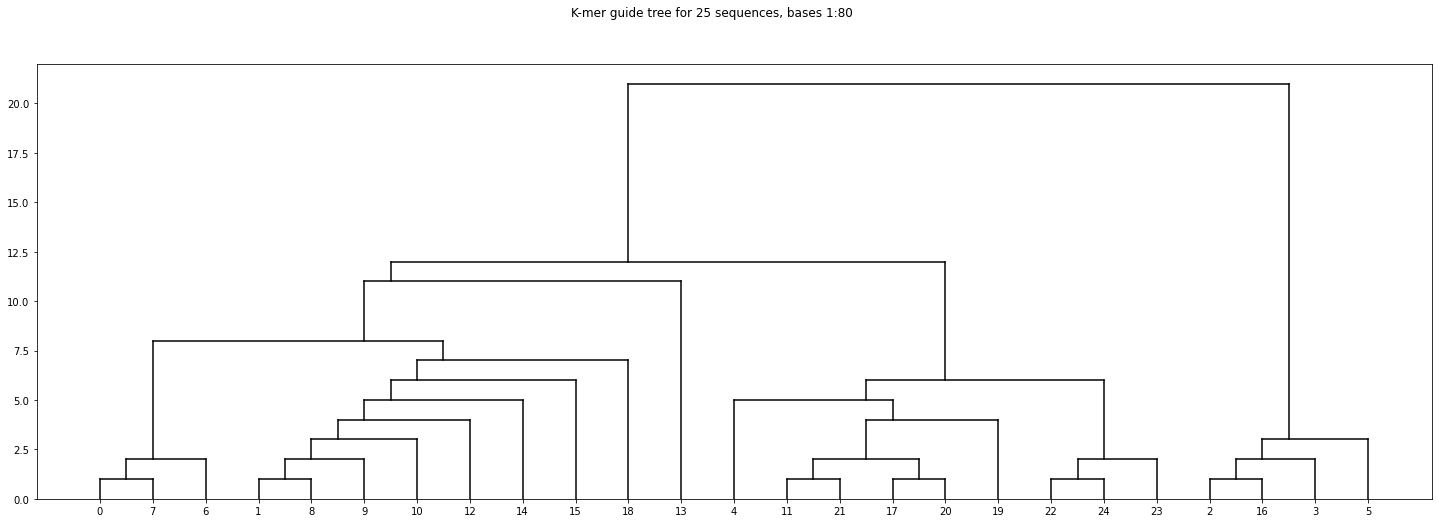

In [23]:
allSequences = [str(elem.seq).upper() for index, elem in enumerate(list(sequenceDict.values()))]

twoMers   = list(itertools.product("ATGC", repeat=2))
twoMers   = ["".join(elem) for elem in twoMers]
threeMers = ["".join(elem) for elem in list(itertools.product("ATGC", repeat=3))]
mersWeUse = np.array(twoMers + threeMers)

print("Each sequence will now have " + str(len(mersWeUse)) + " features.")

# your turn:



# answer
listFeatures = []
for sequence in allSequences:
    featureVector = np.zeros(shape = len(mersWeUse))
    for position in range(0, len(sequence)-1):
        twoMer = sequence[position:position+2]
        featureVector[np.where(mersWeUse == twoMer)] += 1
        #you need to stop tallying 3-mers 1 position earlier than twomers.
        if not position + 3 > len(sequence):
            threeMer = sequence[position:position+3]
            featureVector[np.where(mersWeUse == threeMer)] += 1
        else:
            threeMer = "WillNotMatchAnything" #does nothing
    listFeatures.append(featureVector)

finalSeqFeats  = np.vstack(listFeatures)
kMerClustering = hierarCluster(finalSeqFeats, displayDistMatrix= True)
drawHierarchicalClustering(kMerClustering, title = "K-mer guide tree for all 50 full-length sequences", labels= list(sequenceDict.keys()))

#for the exact same subsequences as above:
def kMerCalculation(sequenceList, kMersToUseList):
    listFeatures = []
    for sequence in sequenceList:
        featureVector = np.zeros(shape = len(kMersToUseList))
        for position in range(0, len(sequence)-1):
            twoMer = sequence[position:position+2]
            featureVector[np.where(kMersToUseList == twoMer)] += 1
            #you need to stop tallying 3-mers 1 position earlier than twomers.
            if not position + 3 > len(sequence):
                threeMer = sequence[position:position+3]
                featureVector[np.where(kMersToUseList == threeMer)] += 1
            else:
                threeMer = "WillNotMatchAnything" #does nothing
        listFeatures.append(featureVector)

    finalSeqFeats  = np.vstack(listFeatures)
    return finalSeqFeats

kMerClusteringSubSeqs = hierarCluster(kMerCalculation(sequences, mersWeUse), displayDistMatrix=True)
drawHierarchicalClustering(kMerClusteringSubSeqs, title = "K-mer guide tree for 25 sequences, bases 1:80")
    


## Going from the guide tree to the multiple sequence alignment

Now that we have our guide tree (either based on k-mers or pairwise distances) we can perform progressive sequence alignment. What I haven't gone into details on is _how_ we align sequence C to already pairwise-aligned sequence A and B. Or two aligned sets of sequences (A, B) and (C, D) to each other. Many complex scoring schemes could be thought up, but the simplest is just to treat every column of the two pairwise alignments as one 'letter' and align the sequences as you normally would using something like Needleman-Wunsch.

To illustrate:
If we have the two protein (sub)sequences: <br>
AIKA <br>
AL-A

and 

ALA <br>
VLA

We could do something like on the following image, where the score for accepting something is the sum (or average) of aligning A with A, A with A, and V with A and V with A for the first position: ![image](MSA.PNG)

Modifying our `alignNW()` function for this is possible, though it would take quite some work and might cause some headaches. Instead, I think you now understand the principles of progressive tree alignment well enough to use something like Clustal Omega. Up to you to:

* Go [here](https://www.ebi.ac.uk/Tools/msa/clustalo/) and use Clustal Omega to align the 50 16s RNA sequences.
* Compare the guide tree to the full k-mer guide tree. If you didn't do this before, you can set `labels = list(sequenceDict.keys())` when plotting the k-mer guide tree so that the leaves are labeled with the sequence ID, just like in Clustal Omega. Do the guide trees look alike or highly dissimilar?
* Download the MSA file. With that in hand, we can _finally_ cluster the sequences based on some distances between them, resulting in one of the most well-known clustering plots in biology: a phylogenetic tree.

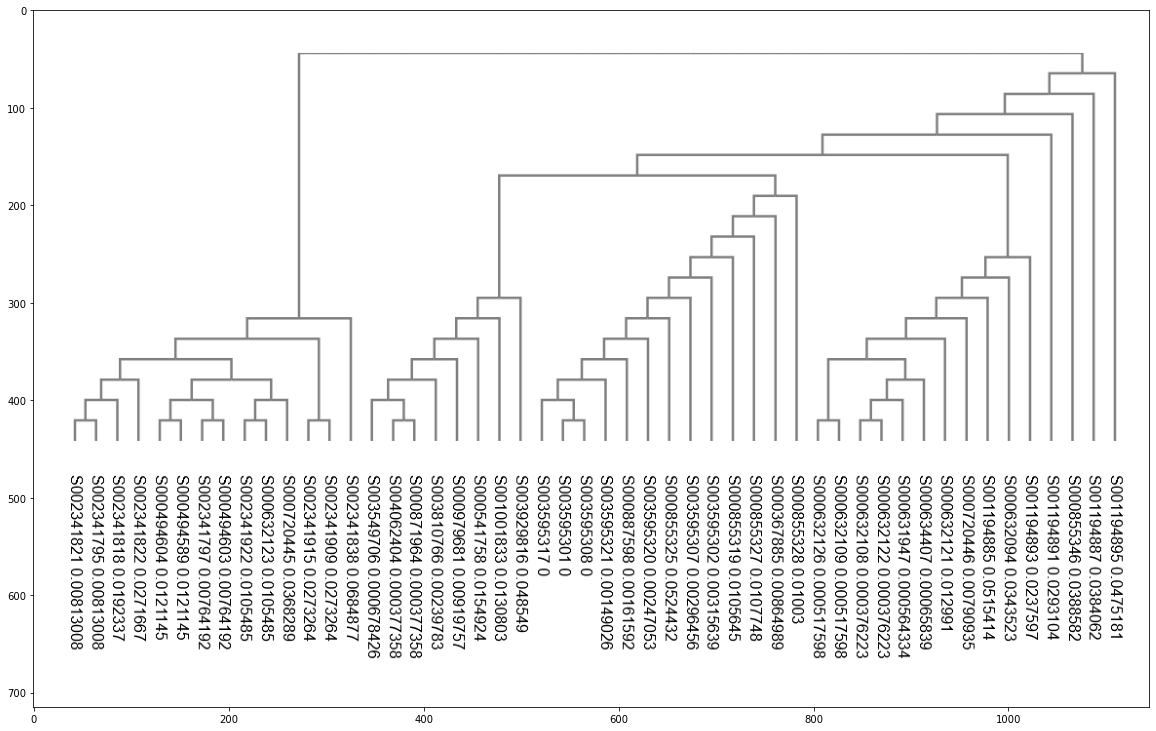

In [29]:
# answer

# They aren't quite the same, which is no surprise: Clustal Omega uses k-tuples, which is slightly different from
# the k-mer method. Still, they are quite similar. You do see, for example, that all sequences with identifiers
# starting with S00063 are clustered together both here and in the Omega guide tree. See the guide tree below:

img = plt.imread("ClustalOmegaTree.PNG")
plt.figure(figsize = (20,20))
plt.imshow(img)

## Using the multiple-sequence alignment to get a phylogenetic tree

Okay then, nearly there. We've clustered the sequences based on some characteristics (pairwise alignment scores or k-mer scores, or k-tuple score) to get a guide tree. Then, we've made a multiple-sequence alignment (MSA) _along_ that guide tree, with the logic that it's easiest to align the most alike sequences first (you'll make the least errors there) and progressively keep adding sequences to that so you'll finally get a quite good (though not optimal) MSA. Now, finally, with the MSA in hand, we have separate features (here, if yours is the same as mine, 1558 features, i.e. 1558 positions in the MSA) on which to cluster our sequences. The only thing that's left to do is to construct a distance matrix, and then cluster.

To construct the distance matrix, we'll just take a simple criterion: the distance from sequence A to sequence B increases by 1 if in position _n_ they do not have the same character (be that A, T, G, C, N, -, etc.). In reality, of course, here too we could use more complex scores, where different substitutions that are more or less likely change the distance more or less. We won't bother with that and keep it simple. Now, it's up to you to make this distance matrix and construct the phylogenetic tree. To do that:

* Use `itertools.combinations` to get every unique combination of 2 sequence indices.
* For each combination of sequences, slide over them letter by letter (or gap by gap). If they are the same: do nothing. If they are different: add 1 to the distance for this pair. Note: you can select the first sequence in the alignment as a string like so: `str(align[0, :].seq)`.
* Put the distances in a matrix.
* Use this distance matrix to make a phylogenetic tree, use average linkage. 
* Finally, compare that phylogenetic tree to the one Clustal Omega gave you.

Hints:
* To get all the sequence names for use as labels, use `[elem.id for elem in align]`.

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,NaN,129.0,153.0,112.0,79.0,123.0,65.0,391.0,389.0,402.0,...,527.0,939.0,1213.0,946.0,1209.0,1216.0,1011.0,1016.0,988.0,1002.0
1,NaN,NaN,134.0,83.0,87.0,87.0,72.0,380.0,379.0,369.0,...,489.0,929.0,1203.0,936.0,1199.0,1206.0,998.0,1008.0,979.0,994.0
2,NaN,NaN,NaN,119.0,111.0,106.0,95.0,372.0,371.0,375.0,...,507.0,931.0,1205.0,938.0,1201.0,1208.0,1004.0,1010.0,982.0,996.0
3,NaN,NaN,NaN,NaN,62.0,77.0,56.0,383.0,381.0,356.0,...,491.0,926.0,1191.0,933.0,1187.0,1194.0,995.0,1002.0,977.0,991.0
4,NaN,NaN,NaN,NaN,NaN,79.0,21.0,341.0,339.0,358.0,...,492.0,894.0,1168.0,901.0,1164.0,1171.0,963.0,972.0,944.0,959.0
5,NaN,NaN,NaN,NaN,NaN,NaN,60.0,330.0,328.0,299.0,...,438.0,892.0,1166.0,899.0,1162.0,1169.0,965.0,971.0,943.0,957.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.0,328.0,339.0,...,478.0,893.0,1167.0,900.0,1163.0,1170.0,966.0,972.0,944.0,958.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,213.0,...,357.0,591.0,865.0,599.0,860.0,867.0,666.0,671.0,643.0,656.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0,...,354.0,590.0,865.0,598.0,860.0,867.0,665.0,670.0,642.0,655.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,166.0,682.0,934.0,670.0,939.0,933.0,695.0,700.0,672.0,685.0


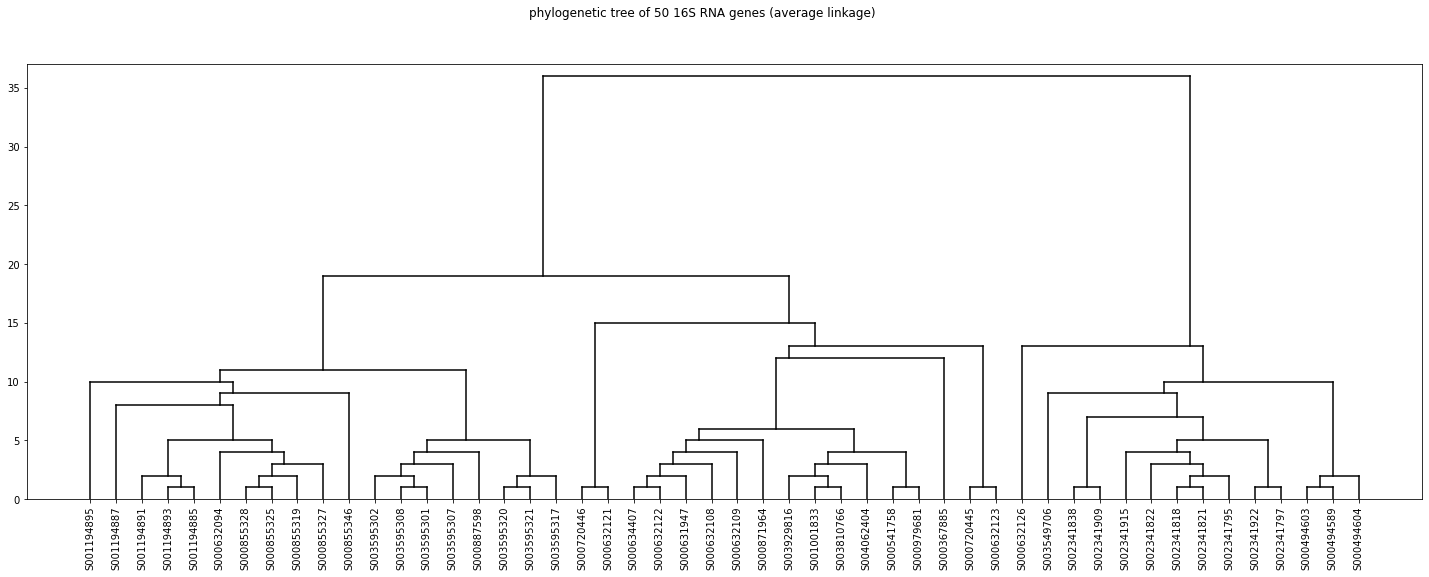

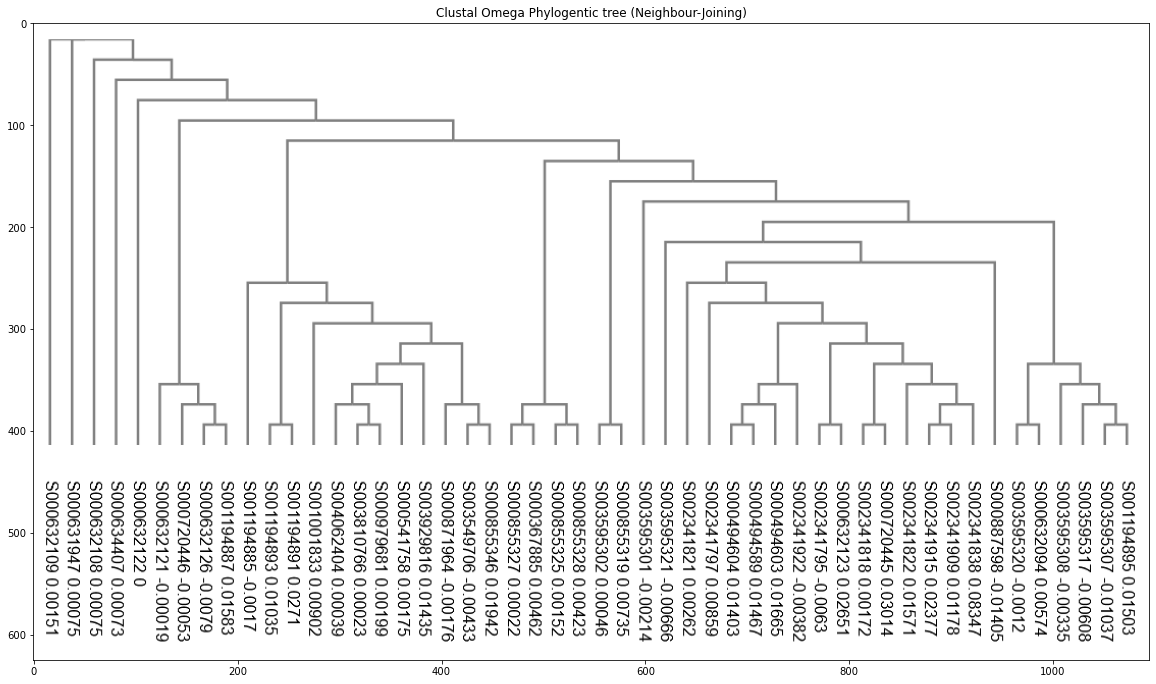

In [59]:
from Bio import AlignIO
yourAlignFile = ''
#align = AlignIO.read(yourAlignFile, "clustal")


#answer
yourAlignFile = "clustalo-I20211203-071322-0822-27889633-p2m_16SMSA.clustal_num"
align         = AlignIO.read(yourAlignFile, format = "clustal")
alignNames    = [elem.id for elem in align]
comboList     = list(itertools.combinations(range(0, len(align)), 2))
matrixClusterScores = np.zeros(shape = (len(align), len(align)))
matrixClusterScores.fill(np.nan)

for seqOneIndex, seqTwoIndex in comboList:
    seqOne = str(align[seqOneIndex, :].seq)
    seqTwo = str(align[seqTwoIndex, :].seq)
    scores = np.sum(np.array([1 if pos != seqTwo[index] else 0 for index, pos in enumerate(seqOne)]))
    matrixClusterScores[seqOneIndex, seqTwoIndex] = scores

clusterOutcome = hierarCluster(align, displayDistMatrix= True, distMatrix = matrixClusterScores)
drawHierarchicalClustering(clusterOutcome, title = "phylogenetic tree of 50 16S RNA genes (average linkage)", labels = alignNames)

# compare to phylogenetic tree Clustal:
# Note that Clustal uses Neighbour-Joining, which is a different way of making hierarchical trees!
img = plt.imread("phyloTreeOmega.PNG")
plt.figure(figsize = (20,20))
plt.imshow(img)
plt.title("Clustal Omega Phylogentic tree (Neighbour-Joining)")
plt.show()

## What I want you to remember here:
* How Needleman-Wunsch works and finds globally optimal pairwise alignments
* How the most well-known application of (hierarchical) clustering in biology, making phylogenetic trees, requires a twist or certain circularity because you don't know which letters in a sequence correspond to which letters in another sequence.
* How this forces you to do an initial clustering on some property (pairwise alignment distances if possible, otherwise k-mer methods or even mBed methods) to make a _guide tree_ that you can then align along.
* That with the guide tree in hand, you can finally calculate the evolutionary distances that you want, and cluster hierarchically based on those to get your phylogenetic tree.
* That the model of evolution used by alignment algorithms is necessarily an indel-model. We know that evolution actually happens via many duplications, sometimes even whole-genome duplications, but alignment programs like Clustal Omega will never tell you directly 'oh, this is a duplication'. Instead you might get 2 equally good global alignments and have to deduce that this happened yourself. In other words: _you still need to think about what the clustering criteria you use actually do for the type of evolution you can measure well in a phylogenetic tree_. Of course there's a lot more nuance, but you can go to Berend for that (see below).


## The end

That concludes our school trip to clustering in phylogenetics. I hope you aren't nauseous from all the candy you kids are wont to consume on such trips. Please do note that this is only a _tiny_ piece of the vast difficulties in the field of phylogenetics, and that you should definitely check out the course taught by Prof. Dr. Berend Snel on the subject for biological background and methodical details.

## Survey
Go on, eat your [survey](https://docs.google.com/forms/d/e/1FAIpQLSfC8YzEjnv0b0iEy7Hgs4fbRMY8oH8XMkSeW3Fl97tmjKseBQ/viewform?usp=sf_link), it'll make you grow big and strong!

